# Predicting age of a child by looking at a hand Xray
The goal of this project is to identify the age of a child from an X-ray of their hand. This data was part of a competition http://rsnachallenges.cloudapp.net/competitions/4. We will build a model inspired by the one used by the winners of the competition. You will also borrow ideas from this fast.ai notebook. https://github.com/fastai/fastai/blob/master/courses/dl2/cifar10-darknet.ipynb

In [54]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import random

In [55]:
import cv2
import matplotlib.pyplot as plt 

## Data

To get the data you can install the kaggle api using: <br/>
`pip install kaggle` <br/>
To get the dataset you can use this command line. (If you don't provide a path you will find your data in /home/user/.kaggle/datasets/kmader/rsna-bone-age/ )<br/>
`kaggle datasets download -d kmader/rsna-bone-age -p PATH` <br/>

In [56]:
PATH = Path("/data2/yinterian/rsna-bone-age/")
list(PATH.iterdir())

[PosixPath('/data2/yinterian/rsna-bone-age/mode951.pth'),
 PosixPath('/data2/yinterian/rsna-bone-age/mode982.pth'),
 PosixPath('/data2/yinterian/rsna-bone-age/model007.pth'),
 PosixPath('/data2/yinterian/rsna-bone-age/model.pth'),
 PosixPath('/data2/yinterian/rsna-bone-age/rsna-bone-age.zip'),
 PosixPath('/data2/yinterian/rsna-bone-age/boneage-test-dataset.csv'),
 PosixPath('/data2/yinterian/rsna-bone-age/model046.pth'),
 PosixPath('/data2/yinterian/rsna-bone-age/boneage-training-dataset'),
 PosixPath('/data2/yinterian/rsna-bone-age/mode_tmp.pth'),
 PosixPath('/data2/yinterian/rsna-bone-age/boneage-test-dataset.zip'),
 PosixPath('/data2/yinterian/rsna-bone-age/model025.pth'),
 PosixPath('/data2/yinterian/rsna-bone-age/boneage-550'),
 PosixPath('/data2/yinterian/rsna-bone-age/boneage-training-dataset.zip'),
 PosixPath('/data2/yinterian/rsna-bone-age/model004.pth'),
 PosixPath('/data2/yinterian/rsna-bone-age/model003.pth'),
 PosixPath('/data2/yinterian/rsna-bone-age/mode1045.pth'),
 Posi

In [57]:
! head /data2/yinterian/rsna-bone-age/boneage-training-dataset.csv

id,boneage,male
1377,180,False
1378,12,False
1379,94,False
1380,120,True
1381,82,False
1382,138,True
1383,150,True
1384,156,True
1385,36,True


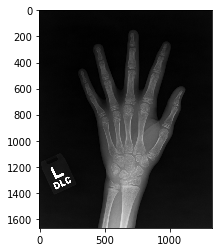

In [58]:
path = PATH/"boneage-training-dataset/9977.png"
im = cv2.imread(str(path))  #.astype(np.float32)/255
plt.imshow(im, cmap='gray')

In [59]:
im = cv2.imread(str(path))  #.astype(np.float32)/255
im.shape

(1668, 1323, 3)

In [60]:
# let's look at the typical size of these images
path = PATH/"boneage-training-dataset"
files = list(path.iterdir())[:200]
dims = [cv2.imread(str(p)).shape for p in files]
dims[:10]

[(1818, 1468, 3),
 (1776, 1412, 3),
 (1935, 1657, 3),
 (1478, 955, 3),
 (1622, 1300, 3),
 (1804, 1303, 3),
 (1526, 1132, 3),
 (2570, 2040, 3),
 (1494, 1104, 3),
 (1673, 1304, 3)]

In [61]:
ratios = [x[0]/x[1] for x in dims]

Here is a presentation with EDA on this data
https://alxndrkalinin.github.io/pdf/2017-12_CFT_BoneAge.pdf

## Data augmentation
The winners of the competition used real-time image augmentation consisting of horizontal/vertical translation, zoom, and rotation of 20 percent/degrees as well as horizontal flip. They use 500x500 images.

In [5]:
# modified from fast.ai
import math
def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]

def center_crop(im, min_sz=None):
    """ Returns a center crop of an image"""
    r,c,*_ = im.shape
    if min_sz is None: min_sz = min(r,c)
    start_r = math.ceil((r-min_sz)/2)
    start_c = math.ceil((c-min_sz)/2)
    return crop(im, start_r, start_c, min_sz, min_sz)

def random_crop(x, target_r, target_c):
    r,c,*_ = x.shape
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(rand_r*(r - target_r)).astype(int)
    start_c = np.floor(rand_c*(c - target_c)).astype(int)
    return crop(x, start_r, start_c, target_r, target_c)

def rotate_cv(im, deg, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

### Center crop, resize, horizontal and vertical translations

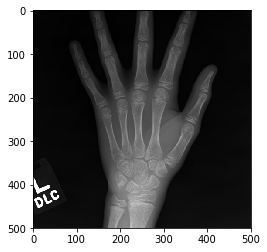

In [63]:
# resize desforms the image a bit
# note that by resizing to a larger number and random cropping we are doing horizontal and vertical translations
# we should try just center cropping the image instead of resizing
path = PATH/"boneage-training-dataset/9977.png"
im = cv2.imread(str(path))
im = center_crop(im)
im = cv2.resize(im, (550, 550))
im = random_crop(im, 500, 500)
plt.imshow(im, cmap='gray')

### Random Rotation (-10, 10) 

1.5266646577520149


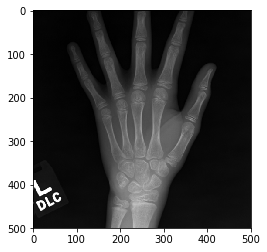

In [65]:
rdeg = (np.random.random()-.50)*20
print(rdeg)
im_rot = rotate_cv(im, rdeg)
plt.imshow(im_rot, cmap='gray')

### Horizontal Flip

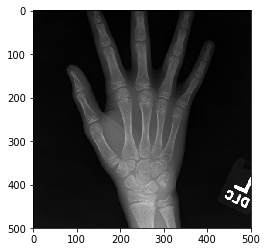

In [67]:
im_f = np.fliplr(im)
plt.imshow(im_f, cmap='gray')

## Split train and validation

In [68]:
df = pd.read_csv(PATH/"boneage-training-dataset.csv")
train = df.sample(frac=0.8, random_state=3).copy()
valid = df.drop(train.index).copy()

## Saving a resized dataset

In [ ]:
# Do this to save time at training.
PATH_550 = PATH/"boneage-550"
#PATH_550.mkdir()

In [ ]:
def get_a_crop(path, sz=550):
    im = cv2.imread(str(path))
    r,c,_ = im.shape
    pad = abs(r-c)//4
    if r > c :
        im2 = cv2.copyMakeBorder(im, 0, 0, pad, pad, cv2.BORDER_REFLECT)
    else:
        im2 = cv2.copyMakeBorder(im, pad, pad, 0, 0, cv2.BORDER_REFLECT)
    return cv2.resize(center_crop(im2), (sz, sz))

In [ ]:
from os import listdir
from os.path import join
def resize_all_images(sz):
    for f in listdir(PATH/"boneage-training-dataset/"):
        old_path = join(PATH/"boneage-training-dataset/", f)
        new_path = join(PATH/"boneage-550/", f)
        img2 = get_a_crop(old_path,sz)
        cv2.imwrite(new_path, img2)

In [ ]:
path = PATH/"boneage-training-dataset/10007.png"
im2 = get_a_crop(path)
print(im2.shape)
plt.imshow(im2, cmap='gray')

In [ ]:
list(PATH.iterdir())

## Dataset

In [7]:
class BoneAgeDataset(Dataset):
    def __init__(self, df, transforms=True, sz=400):
        self.path_to_images = PATH/"boneage-550/"
        self.transforms = transforms
        self.df = df
        self.sz = sz
        self.sz2 = int(sz*1.05)
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = str(self.path_to_images) + "/" + str(row["id"]) + ".png"
        y = row["boneage"]
        x = cv2.imread(str(path)).astype(np.float32)/255
        x = center_crop(x)
        if self.transforms:
            x = cv2.resize(x, (self.sz2, self.sz2))
            x = random_crop(x, self.sz, self.sz)
            rdeg = (np.random.random()-.50)*20
            x = rotate_cv(x, rdeg)
            if np.random.random() > 0.8: x = np.fliplr(x).copy() 
        else:
            x = cv2.resize(x, (self.sz, self.sz))
        x = x[:,:,0]
        return x[None], y

In [8]:
train_ds = BoneAgeDataset(train)
valid_ds = BoneAgeDataset(valid, transforms=False)

In [9]:
batch_size = 16
train_dl = DataLoader(train_ds, batch_size=batch_size)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [69]:
# run this multiple times to get different images
x, y = train_ds[10]
#plt.imshow(x[0], cmap='gray')

In [70]:
x.shape

(1, 400, 400)

## Model
This model is adapted from fast.ai

In [10]:
# From fast.ai
class Flatten(nn.Module):
    def __init__(self): super().__init__()
    def forward(self, x): return x.view(x.size(0), -1)

In [11]:
# From fast.ai
def conv_layer(ni, nf, ks=3, stride=1):
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=ks, bias=False, stride=stride, padding=ks//2),
        nn.BatchNorm2d(nf, momentum=0.01),
        nn.LeakyReLU(negative_slope=0.1, inplace=True))

In [12]:
class ResLayer(nn.Module):
    def __init__(self, ni):
        super().__init__()
        self.conv1=conv_layer(ni, ni//2, ks=1)
        self.conv2=conv_layer(ni//2, ni, ks=3)
        
    def forward(self, x): return x.add(self.conv2(self.conv1(x)))

In [13]:
class Darknet(nn.Module):
    def make_group_layer(self, ch_in, num_blocks, stride=1):
        return [conv_layer(ch_in, ch_in*2,stride=stride)
               ] + [(ResLayer(ch_in*2)) for i in range(num_blocks)]

    def __init__(self, num_blocks, nf=32):
        super().__init__()
        layers = [conv_layer(1, nf, ks=3, stride=1)]
        for i,nb in enumerate(num_blocks):
            layers += self.make_group_layer(nf, nb, stride=2)
            nf *= 2
        layers += [nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(nf, 1)]
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x): return self.layers(x)

In [14]:
m = Darknet([1, 2, 4, 6, 3])

In [ ]:
m = m.cuda()

In [ ]:
x,y = next(iter(train_dl))
x = Variable(x).cuda().float()
y = Variable(y).cuda().float()

In [ ]:
x.shape

In [ ]:
m(x).shape

In [ ]:
m

In [ ]:
1e-5*100000

In [ ]:
len(train_dl)

## Finding optimal learning rate range
From this paper https://arxiv.org/pdf/1506.01186.pdf.
This an implementation of the "LR range test". Run your model for several epochs while letting the learning rate increase linearly between low and high LR values. Next, plot the loss versus learning rate. Note the learning rate value when the loss starts to decrease and when the loss slows, becomes ragged, or increases. In the example below the range seem to be from `1e-5` to `0.012`.

In [15]:
def get_optimizer(model, lr = 0.01, wd = 0.0):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = torch.optim.Adam(parameters, lr=lr, weight_decay=wd)
    return optim

In [16]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

def LR_range_finder(model, train_dl, lr_low=1e-5, lr_high=1, epochs=2):
    losses = []
    p = PATH/"mode_tmp.pth"
    save_model(model, str(p))
    iterations = epochs * len(train_dl)
    delta = (lr_high - lr_low)/iterations
    lrs = [lr_low + i*delta for i in range(iterations)]
    model.train()
    ind = 0
    for i in range(epochs):
        for j, (x, y) in enumerate(train_dl):
            optim = get_optimizer(model, lr=lrs[ind])
            x = Variable(x).cuda().float()
            y = Variable(y).cuda().float()
            out = model(x)
            loss = F.l1_loss(out, y)
            optim.zero_grad()
            loss.backward()
            optim.step()
            losses.append(loss.data[0])
            ind +=1
            
    load_model(model, str(p))
    return lrs, losses 

In [17]:
model = Darknet([1, 2, 4, 6, 3]).cuda()
lrs, losses = LR_range_finder(model, train_dl)

KeyboardInterrupt: 

In [ ]:
# first plot the whole graph
plt.plot(lrs[:80], losses[:80])
plt.show()

## Trainning with Triangular learning rate policy.

Before training with this policy you have to estimate the range of learning rates using previous function.

In [18]:
def get_triangular_lr(lr_low, lr_high, stepesize):
    delta = (lr_high - lr_low)/(stepesize -1)
    lrs1 = [lr_low + i*delta for i in range(stepesize)]
    lrs2 = [lr_high - i*delta for i in range(stepesize)]
    return lrs1+lrs2
lrs = get_triangular_lr(0, 1, 10)
print(lrs)

[0.0, 0.1111111111111111, 0.2222222222222222, 0.3333333333333333, 0.4444444444444444, 0.5555555555555556, 0.6666666666666666, 0.7777777777777777, 0.8888888888888888, 1.0, 1.0, 0.8888888888888888, 0.7777777777777778, 0.6666666666666667, 0.5555555555555556, 0.4444444444444444, 0.33333333333333337, 0.22222222222222232, 0.11111111111111116, 0.0]


In [19]:
def get_triangular_lr2(lr_low, lr_high, stepesize):
    iterations = 2*stepesize
    iter1 = int(0.35*iterations)
    iter2 = int(0.85*iter1)
    iter3 = iterations - iter1 - iter2
    delta1 = (lr_high - lr_low)/iter1
    delta2 = (lr_high - lr_low)/(iter1 -1)
    lrs1 = [lr_low + i*delta1 for i in range(iter1)]
    lrs2 = [lr_high - i*(delta1) for i in range(0, iter2)]
    delta2 = (lrs2[-1] - lr_low)/(iter3)
    lrs3 = [lrs2[-1] - i*(delta2) for i in range(1, iter3+1)]
    return lrs1+lrs2+lrs3

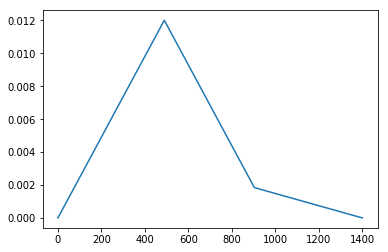

In [20]:
lrs = get_triangular_lr2(1e-5, 0.012, 700)
plt.plot(lrs)
plt.show()

In [43]:
def train_triangular_policy(model, train_dl, valid_dl, lr_low=1e-5, lr_high=0.012):
    idx = 0
    epochs = 4
    stepesize = 2*len(train_dl)
    lrs = get_triangular_lr2(lr_low, lr_high, stepesize)
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for i, (x, y) in enumerate(train_dl):
            optim = get_optimizer(model, lr = lrs[idx], wd =0)
            batch = x.shape[0]
            x = Variable(x).cuda().float()
            y = Variable(y).cuda().float()
        
            out = model(x)
            loss = F.l1_loss(out, y)
            optim.zero_grad()
            loss.backward()
            optim.step()
            idx += 1
            total += batch
            sum_loss += batch*(loss.data[0])
        print("train loss", sum_loss/total)
        val_loss(model, valid_dl)
    return sum_loss/total

In [22]:
def val_loss(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    for i, (x, y) in enumerate(valid_dl):
        batch = x.shape[0]
        x = Variable(x).cuda().float()
        y = Variable(y).cuda().float()
        out = model(x)
        loss = F.l1_loss(out, y)
        sum_loss += batch*(loss.data[0])
        total += batch
    print("val loss", sum_loss/total)
    return sum_loss/total

In [23]:
model = Darknet([1, 2, 4, 6, 3]).cuda()

In [44]:
from datetime import datetime

def training_loop(model, train_dl, valid_dl, steps=3, lr_low=1e-5, lr_high=0.012):
    for i in range(steps):
        start = datetime.now() 
        loss = train_triangular_policy(model, train_dl, valid_dl, lr_low, lr_high)
        end = datetime.now()
        t = 'Time elapsed {}'.format(end - start)
        print("----End of step", t)

In [25]:
training_loop(model, 5)

train loss 45.623061737535444
val loss 72.64290736876812
train loss 33.96514722431057
val loss 35.516014837254424
train loss 31.221370589261674
val loss 31.886717078612023
train loss 29.323143192154763
val loss 28.05830501281109
----End of step Time elapsed 0:23:41.516299
train loss 29.417924961706778
val loss 36.223304899791984
train loss 25.385740252171626
val loss 26.900981534009507
train loss 19.42219648494488
val loss 18.386266045112823
train loss 17.54091583639132
val loss 15.574896247494703
----End of step Time elapsed 0:23:19.447646
train loss 19.2133062663075
val loss 35.09704175097521
train loss 21.49387811907858
val loss 21.830231925970406
train loss 17.544949240698216
val loss 16.363899745230256
train loss 15.900487466283355
val loss 14.082288673999855
----End of step Time elapsed 0:22:50.967878
train loss 17.37976834776144
val loss 50.26269467117104
train loss 19.754191285283753
val loss 40.49533951991518
train loss 16.396642890814476
val loss 17.513908811262162
train loss

In [26]:
training_loop(model, 3, lr_low=1e-5, lr_high=0.003)

train loss 14.263382120970894
val loss 13.272155406265199
train loss 14.783731592718846
val loss 16.94928747959122
train loss 13.919891743844772
val loss 12.100011907240212
train loss 13.62299452150337
val loss 12.008184200047879
----End of step Time elapsed 0:23:20.455724
train loss 13.848923162043844
val loss 13.725671961040936
train loss 14.34631811590589
val loss 15.342303196652177
train loss 13.559383945501008
val loss 11.911217498174269
train loss 13.206149436730627
val loss 11.735988587448277
----End of step Time elapsed 0:23:44.948994
train loss 13.43918061707771
val loss 14.466383988473455
train loss 14.16615095959982
val loss 15.315539631552397
train loss 13.232009625668828
val loss 11.840880841702152
train loss 12.8478607754722
val loss 11.540226731387326
----End of step Time elapsed 0:23:41.456009


In [28]:
training_loop(model, 3, lr_low=1e-5, lr_high=0.003)

train loss 13.152737889255354
val loss 16.778002031826954
train loss 13.935005700698113
val loss 15.376870121301685
train loss 12.927443265465918
val loss 11.50160617737615
train loss 12.524969114374862
val loss 11.414389673062113
----End of step Time elapsed 0:23:13.271924
train loss 12.901719939426313
val loss 12.369769128894731
train loss 13.652108467231363
val loss 12.843103706033148
train loss 12.782786859819916
val loss 11.491814626199115
train loss 12.276938548160386
val loss 11.251593628353207
----End of step Time elapsed 0:23:49.900147
train loss 12.65916109193788
val loss 13.824012242074433
train loss 13.296641189570659
val loss 12.547889372169925
train loss 12.299246762408316
val loss 11.549489819937335
train loss 11.898699179762879
val loss 11.10967648965229
----End of step Time elapsed 0:23:43.220666


In [29]:
training_loop(model, 3, lr_low=1e-5, lr_high=0.003)

train loss 12.36981978328061
val loss 12.233699474138083
train loss 13.099694195960154
val loss 13.725741510444175
train loss 12.055306261743022
val loss 10.920661044442209
train loss 11.55018129045326
val loss 10.963666866735085
----End of step Time elapsed 0:23:46.093495
train loss 11.964053231597667
val loss 12.50550051287561
train loss 12.724950222681223
val loss 12.561069826584406
train loss 11.707698583437484
val loss 10.982128026842787
train loss 11.227378725733791
val loss 10.844734530709832
----End of step Time elapsed 0:23:51.726653
train loss 11.646148155319027
val loss 15.242850980524219
train loss 12.57666299884035
val loss 11.134821988589039
train loss 11.53858673439022
val loss 10.762744333326202
train loss 11.082182285393156
val loss 10.677097285011286
----End of step Time elapsed 0:23:49.416767


In [30]:
training_loop(model, 3, lr_low=1e-5, lr_high=0.003)

train loss 11.49689058842065
val loss 12.739510871984011
train loss 12.44505853092414
val loss 11.546216138859386
train loss 11.192747556958826
val loss 10.864729668770774
train loss 10.647953678493705
val loss 10.554042250461563
----End of step Time elapsed 0:23:51.858458
train loss 11.073326064143926
val loss 12.313348615859635
train loss 12.125249311205346
val loss 11.755949643563884
train loss 11.003178162905137
val loss 10.867132850907135
train loss 10.48366370037108
val loss 10.493077545861796
----End of step Time elapsed 0:23:51.417922
train loss 10.892317548168226
val loss 11.862814212771847
train loss 12.00909862259309
val loss 13.837489718014432
train loss 10.805907002264805
val loss 10.558478773632851
train loss 10.300284773710993
val loss 10.305330107081607
----End of step Time elapsed 0:23:48.976277


In [31]:
training_loop(model, 3, lr_low=1e-5, lr_high=0.003)

train loss 10.841456693350022
val loss 10.870390486660503
train loss 11.867366835954984
val loss 11.279734305216149
train loss 10.523179212591554
val loss 10.495949729296255
train loss 10.02298401836267
val loss 10.370062710839921
----End of step Time elapsed 0:23:51.382056
train loss 10.46892860923795
val loss 11.153744964539106
train loss 11.679356946216394
val loss 11.0543840780417
train loss 10.39783201993711
val loss 10.754701489592998
train loss 9.906225928916179
val loss 10.21090637890712
----End of step Time elapsed 0:23:47.217277
train loss 10.367800475419342
val loss 14.13131189459756
train loss 11.514203224632073
val loss 13.634746556051377
train loss 10.346584185463124
val loss 10.485832981227599
train loss 9.832593202283732
val loss 10.257340687593707
----End of step Time elapsed 0:23:49.101725


In [32]:
p = PATH/"model025.pth"
save_model(model, p)

In [33]:
training_loop(model, 3, lr_low=1e-5, lr_high=0.003)

train loss 10.320222003878918
val loss 12.01687013866597
train loss 11.499148212583725
val loss 13.043459376487156
train loss 10.13222805332861
val loss 10.655708781884456
train loss 9.634237906684463
val loss 10.119181758538774
----End of step Time elapsed 0:23:25.615686
train loss 10.123079956316335
val loss 11.283315898311413
train loss 11.363553073363919
val loss 14.866108746872735
train loss 10.005506338739032
val loss 10.578337949197696
train loss 9.549798419282013
val loss 10.159578586551143
----End of step Time elapsed 0:23:37.564133
train loss 10.074453023985576
val loss 11.844373743842274
train loss 11.26691515337713
val loss 11.221265520584385
train loss 9.874618237053324
val loss 10.219159203422722
train loss 9.431668565417201
val loss 10.049855900793961
----End of step Time elapsed 0:23:37.922840


In [34]:
p = PATH/"model004.pth"
save_model(model, p)

In [35]:
training_loop(model, 3, lr_low=1e-5, lr_high=0.003)

train loss 9.898709399551995
val loss 16.53361714519649
train loss 11.093989599777858
val loss 11.84160546099355
train loss 9.895924568459847
val loss 10.052780738999974
train loss 9.334162484383675
val loss 9.951132005968327
----End of step Time elapsed 0:23:46.645139
train loss 9.890184978697224
val loss 10.980202742931297
train loss 10.969015524708512
val loss 11.539697710622596
train loss 9.689701637081283
val loss 10.179851061573679
train loss 9.186172535261369
val loss 9.953562956589918
----End of step Time elapsed 0:22:45.845982
train loss 9.767673405656636
val loss 11.647481587082503
train loss 10.833313521030625
val loss 11.349242242908403
train loss 9.69085806563891
val loss 10.096809537707578
train loss 9.204073897531996
val loss 9.825388880403716
----End of step Time elapsed 0:22:42.097060


In [36]:
p = PATH/"mode982.pth"
save_model(model, p)

In [37]:
training_loop(model, 5, lr_low=1e-5, lr_high=0.003)

train loss 9.659912690521763
val loss 13.264713642807067
train loss 10.738028198394941
val loss 11.036421859765412
train loss 9.499015757250401
val loss 10.036042030419177
train loss 9.082798625376242
val loss 9.778036493426935
----End of step Time elapsed 0:27:03.286398
train loss 9.543949227205932
val loss 11.826622597666415
train loss 10.771479258677664
val loss 11.87407975949341
train loss 9.534867190549036
val loss 10.036091538292373
train loss 8.96284408410532
val loss 9.759170072405798
----End of step Time elapsed 0:26:03.244225
train loss 9.410974728102868
val loss 10.181903873144115
train loss 10.636254415626462
val loss 11.126130443636526
train loss 9.444923675382842
val loss 10.007536090999062
train loss 9.027386239882041
val loss 9.734913206592049
----End of step Time elapsed 0:23:47.838629
train loss 9.33647258625074
val loss 10.632103466968703
train loss 10.590949359031342
val loss 11.436139217924259
train loss 9.209595547049473
val loss 9.935904312285047
train loss 8.773

In [38]:
p = PATH/"mode971.pth"
save_model(model, p)

In [39]:
training_loop(model, 5, lr_low=1e-5, lr_high=0.001)

train loss 8.78742747193865
val loss 10.88776768284313
train loss 9.114739328513522
val loss 10.209122250895005
train loss 8.679072800990859
val loss 9.860550794972019
train loss 8.453682288174493
val loss 9.607586841749635
----End of step Time elapsed 0:23:58.539779
train loss 8.579691422305833
val loss 10.062300491484265
train loss 8.87156249269502
val loss 10.06594440390627
train loss 8.606406032725975
val loss 9.73991787840127
train loss 8.401609366896462
val loss 9.60187570222496
----End of step Time elapsed 0:23:16.432014
train loss 8.478819820356033
val loss 10.873824326789729
train loss 8.77759507820431
val loss 9.845678193336626
train loss 8.483425294836588
val loss 9.665561939212276
train loss 8.391216542749389
val loss 9.549710633733932
----End of step Time elapsed 0:22:39.185608
train loss 8.468748176212483
val loss 10.361373977751887
train loss 8.790247539921433
val loss 9.98481042530686
train loss 8.374656195351786
val loss 9.691897973855463
train loss 8.254242630942581
v

In [53]:
p = PATH/"mode951.pth"
save_model(model, p)

## Experiments with sizes and bigger models

In [41]:
model2 = Darknet([1, 3, 4, 6, 4]).cuda()

In [42]:
#training with different sizes
size=128
train_ds = BoneAgeDataset(train, sz=size)
valid_ds = BoneAgeDataset(valid, transforms=False, sz=size)
batch_size = 32
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)

In [ ]:
lrs, losses = LR_range_finder(model2, train_dl=train_dl, lr_low=1e-6, lr_high=1, epochs=3)

In [ ]:
plt.plot(lrs[3:70], losses[3:70])
plt.show()

In [ ]:
lrs[17]

## Training a bigger model using different image sizes
First training with size=(128, 128). 

In [45]:
training_loop(model2, train_dl, valid_dl, steps=3)

train loss 48.90728611473003
val loss 93.56412246546795
train loss 34.57827247969754
val loss 33.69706777804055
train loss 28.725175256924796
val loss 35.52290987684838
train loss 25.588178727090128
val loss 25.563021621280583
----End of step Time elapsed 0:10:05.260037
train loss 26.756245738156238
val loss 35.534808537772875
train loss 28.169966735597857
val loss 26.78992904886946
train loss 22.711112914821275
val loss 21.575234128027848
train loss 20.80687678156836
val loss 19.726066297429785
----End of step Time elapsed 0:10:00.626601
train loss 22.25122504887017
val loss 26.30180537369779
train loss 25.262563995828664
val loss 29.938739395444117
train loss 20.703193041434407
val loss 19.034121057327354
train loss 18.44051714791381
val loss 17.18224536342152
----End of step Time elapsed 0:10:01.979604


In [46]:
size=300
train_ds = BoneAgeDataset(train, sz=size)
valid_ds = BoneAgeDataset(valid, transforms=False, sz=size)
batch_size = 20
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)

In [47]:
training_loop(model2, train_dl, valid_dl, steps=3)

train loss 26.044993554651352
val loss 40.75597686223053
train loss 23.944002681780955
val loss 57.47501281024349
train loss 17.839883319213094
val loss 15.296197219655024
train loss 15.979709047878423
val loss 14.365781182055432
----End of step Time elapsed 0:17:45.754115
train loss 17.707598087962264
val loss 32.35183999578127
train loss 20.0995422680511
val loss 17.7226585596918
train loss 16.515401925945177
val loss 15.158796330088192
train loss 14.779526117169617
val loss 13.165533575531418
----End of step Time elapsed 0:17:58.419137
train loss 16.35949897009904
val loss 32.226625985516904
train loss 19.121577081104633
val loss 14.921346455694286
train loss 15.567782258831459
val loss 13.205089519177044
train loss 14.122914174654898
val loss 12.474478208101713
----End of step Time elapsed 0:17:53.501802


In [48]:
size=400
train_ds = BoneAgeDataset(train, sz=size)
valid_ds = BoneAgeDataset(valid, transforms=False, sz=size)
batch_size = 16
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)

In [49]:
training_loop(model2, train_dl, valid_dl, steps=3)

train loss 16.704957682616836
val loss 60.258662496834496
train loss 18.999557165031874
val loss 25.099690439585746
train loss 15.150926884225722
val loss 14.32799159450062
train loss 14.049556574508118
val loss 12.061274733456424
----End of step Time elapsed 0:23:55.504077
train loss 15.559061320381721
val loss 26.467239134846746
train loss 17.552685243710734
val loss 14.003673973960785
train loss 14.85655387086667
val loss 12.284045111272754
train loss 13.738901040660153
val loss 11.946764532296456
----End of step Time elapsed 0:23:50.679160
train loss 15.241433451203811
val loss 39.308067379254936
train loss 17.53291383055703
val loss 16.993585914775174
train loss 14.453696711163346
val loss 13.926190339223815
train loss 13.261515430681461
val loss 11.630616101832922
----End of step Time elapsed 0:23:50.308037


In [50]:
training_loop(model2, train_dl, valid_dl, steps=3)

train loss 14.61832049580889
val loss 55.65187916161993
train loss 16.87780511096845
val loss 27.70183369321165
train loss 14.023264554957944
val loss 12.319073411607251
train loss 12.694166431224716
val loss 11.279602157417315
----End of step Time elapsed 0:23:48.021861
train loss 14.11314756828442
val loss 24.021565754199955
train loss 16.709299003112562
val loss 19.544616812661374
train loss 13.548484523677534
val loss 12.343640225355253
train loss 12.368803217692493
val loss 10.90747644180915
----End of step Time elapsed 0:23:48.558980
train loss 13.747964949753891
val loss 23.246584095905735
train loss 16.196004100190436
val loss 32.43624926634387
train loss 13.514724510254124
val loss 11.265589320782533
train loss 12.175860290686147
val loss 10.807946668741346
----End of step Time elapsed 0:23:49.148442


In [51]:
training_loop(model2, train_dl, valid_dl, steps=3)

train loss 13.217544223782754
val loss 13.720398756930225
train loss 15.860890428662383
val loss 12.165713792750989
train loss 13.175634879661345
val loss 11.24549870411618
train loss 11.742005138073937
val loss 10.713178320029348
----End of step Time elapsed 0:25:18.767624
train loss 13.076373187528397
val loss 13.22388572602117
train loss 15.676575249611345
val loss 14.120502409908527
train loss 12.858752071544334
val loss 10.59982015971245
train loss 11.394614895007598
val loss 10.486111295308318
----End of step Time elapsed 0:24:48.956338
train loss 12.616183464325553
val loss 39.17918028139482
train loss 15.163319795854099
val loss 15.489150734008257
train loss 12.540265934899065
val loss 10.939147332847165
train loss 11.20275534831068
val loss 10.450658135712855
----End of step Time elapsed 0:24:32.771247


In [52]:
training_loop(model2, train_dl, valid_dl, steps=10, lr_low=1e-5, lr_high=0.001,)

train loss 10.889478781967927
val loss 10.830256437139791
train loss 11.110302451344804
val loss 10.352339962377707
train loss 10.755905138889736
val loss 10.19043447931639
train loss 10.731803673040833
val loss 10.15784996298927
----End of step Time elapsed 0:23:50.630481
train loss 10.774833302417989
val loss 10.522304380630143
train loss 10.792620678441425
val loss 10.416687793716564
train loss 10.429525662725704
val loss 10.081736478419836
train loss 10.372804753453542
val loss 10.056434363623067
----End of step Time elapsed 0:23:52.514577
train loss 10.502904778441868
val loss 10.192705640709656
train loss 10.48187693799023
val loss 10.354615402070422
train loss 10.249422290963453
val loss 10.21752375860615
train loss 10.10243898086026
val loss 10.047810630889094
----End of step Time elapsed 0:23:49.094220
train loss 10.182357430966148
val loss 10.350297017290325
train loss 10.398201023838732
val loss 10.075562195774111
train loss 10.046455453911815
val loss 10.048704160951981
tra

In [ ]:
#### start here

In [ ]:
training_loop(model2, steps=3, lr_low=1e-5, lr_high=0.005)

In [ ]:
p = PATH/"mode1045.pth"
save_model(model, p)

In [ ]:
p = PATH/"mode1045.pth"
model.load_state_dict(torch.load(p))

In [ ]:
training_loop(model2, steps=3, lr_low=1e-5, lr_high=0.005)

In [ ]:
training_loop(model2, steps=3, lr_low=1e-5, lr_high=0.003)

In [ ]:
val_loss(model, valid_dl)

## Saving and loading 

In [ ]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
model.load_state_dict(torch.load(p))
p = PATH/"model001.pth"
save_model(model, p)

# References

* https://www.16bit.ai/blog/ml-and-future-of-radiology
* https://stanfordmedicine.app.box.com/s/vhq1zop1867gr9rwnan4byj8lfxue173
* https://github.com/fastai/fastai/blob/master/courses/dl2/cifar10-darknet.ipynb

## Want a beter model model?
In this paper a better model is proposed.
https://openreview.net/pdf?id=S1Ja7-2jf